###
FEniCS tutorial demo program: Heat equation with Dirichlet conditions.
###
Test problem is chosen to give an exact solution at all nodes of the mesh.

We want to solve:
\[
\frac{du}{dt} = \Delta u + f
\]
in a unit square $\Omega$. With Dirichlet boundary condtions:

\[
u|_{\partial\Omega} = u_D
\]

and initial conditions

\[
u(t=0) = u_0
\]

We choose $u(t,x,y) = 1 + x^2 + \alpha y^2 + \beta t$ and set the initial and boundary values to coincide with it.
This geves a source given by:

\[
f = \beta - 2 - 2 \alpha
\]


In [51]:
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as mpl

In [52]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

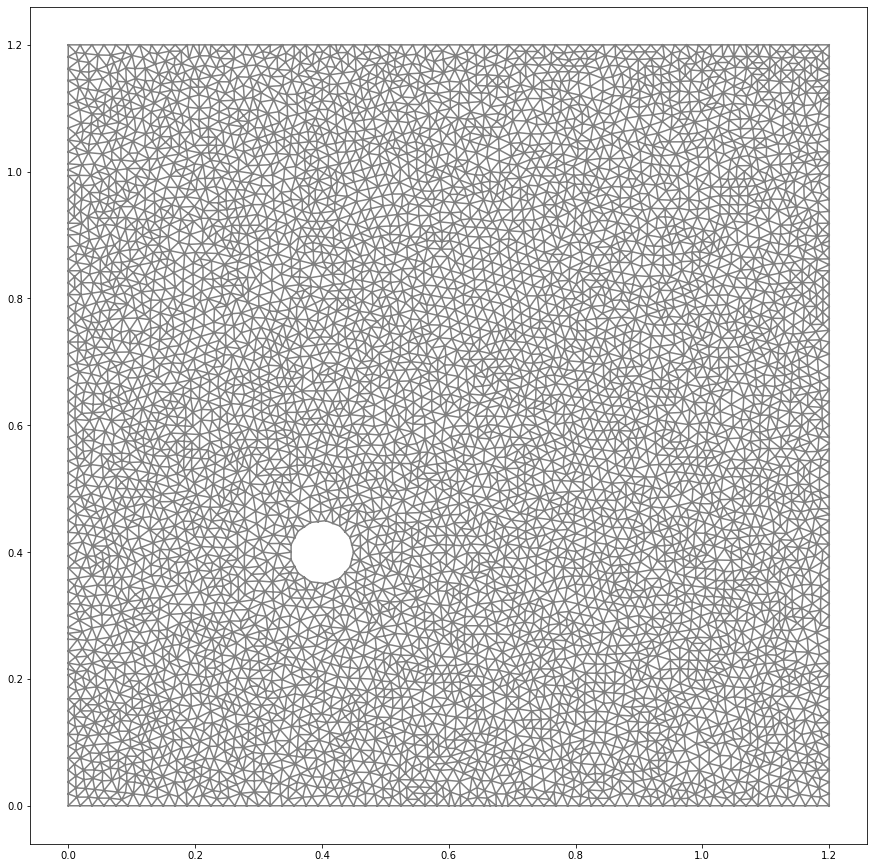

In [53]:
length = 1.2
width = 1.2
center_x = 0.4
center_y = 0.4 #width / 2.
radious = 0.05 #width / 4.
    
channel = Rectangle(Point(0, 0), Point(length, width))
cylinder = Circle(Point(center_x, center_y), radious)
domain = channel - cylinder


mesh = generate_mesh(domain, 64)

# Plot mesh
mpl.figure(figsize=(15,20))
plot(mesh)

In [54]:
# Define function space

V = FunctionSpace(mesh, 'P', 1)

# To use to define boundary condition and initial conditions 
u_D_0 = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)
u_D_1 = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t*x[0]',
                 degree=2, alpha=alpha, beta=beta, t=0)

u_B = u_D_0
u_n = Function(V, name = 'temperature')
#u_i = project(Expression(('1.0','0.0'), degree=2), V)
u_n.assign(u_D_1)

In [55]:
tol = 1.E-4
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

class outer_0(SubDomain):
    def inside(self, x, on_boundary):
        return  near(x[0], 0, tol) or near(x[0],length, tol) \
            or near(x[1],0, tol) or near(x[1],width, tol)
outer0 = outer_0()
outer0.mark(boundary_markers, 0)

class cyl_1(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and x[0]>center_x - radious - tol and x[0]<center_x + radious + tol and x[1]>center_y - radious - tol and x[1]<center_y + radious + tol
cyl1 = cyl_1()
cyl1.mark(boundary_markers,1)

#u_outer = u_B
u_outer = Constant(0)
#u_cyl = u_B
u_cyl = Constant(1)
bc_out = DirichletBC(V, u_outer, outer0)
bc_cyl = DirichletBC(V, u_cyl, cyl1)
    
bcs = [bc_out, bc_cyl]

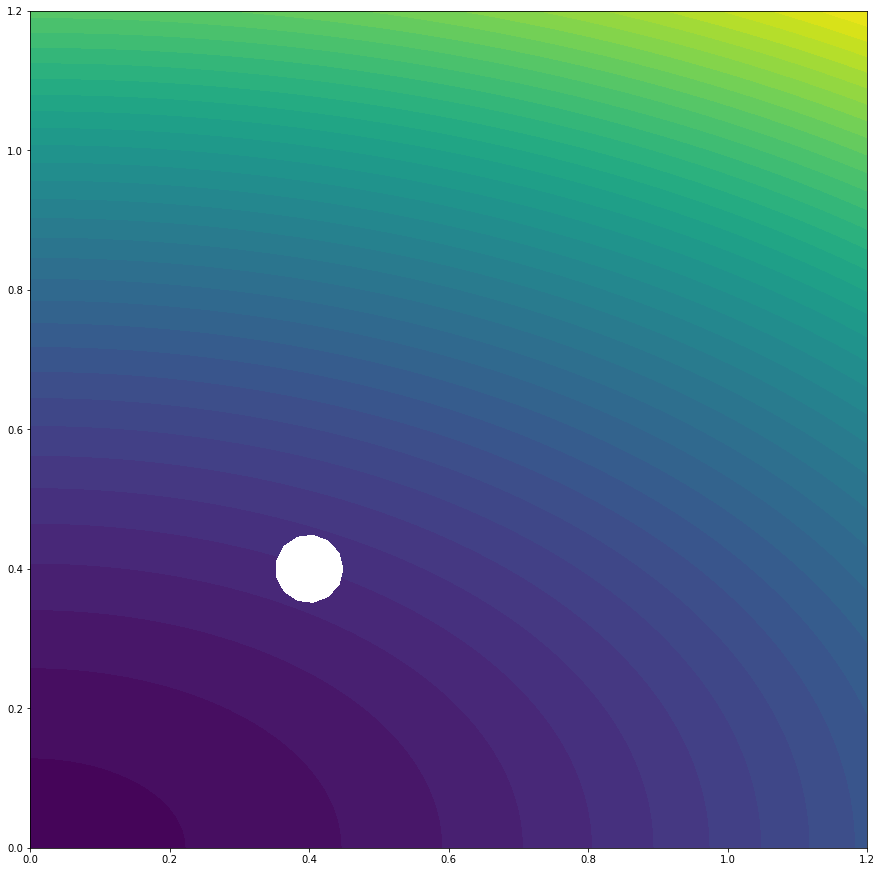

In [56]:
# Define initial value
u_0 = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t*x[0]',
                 degree=2, alpha=alpha, beta=beta, t=0)
u_n = Function(V, name = 'temperature')
u_n = interpolate(u_0, V)
#u_n = project(u_D, V)
mpl.figure(figsize=(15,20))

plot(u_n)
#plot(mesh)

We are now ready to define the weak, variational problem:
To do that we choose to solve it using an implicit Euler method, that is,

\[
u^{n+1} = u^{n} + dt [\Delta u^{n+1} + f^n]
\]

calling $u^{n+1} = u$ we get,
\[
\int_{\Omega} u v + dt \nabla v \cdot \nabla u - (u^n + dt f^n) v = 0 \;\;\;\; \forall v \in V
\]



In [57]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
#f = Constant(beta - 2 - 2*alpha)
f = Expression('beta*x[0] - 2 - 2*alpha',
                 degree=2, alpha=alpha, beta=beta, t=0)


F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

In [58]:
vtkfile_u = File('Heat/temperature.pvd')
    
#vtkfile_u << interpolate(u_0, V)
#vtkfile_u << u_n

step = 0, t = 0.20, error = 6.76
step = 1, t = 0.40, error = 6.76
step = 2, t = 0.60, error = 6.76
step = 3, t = 0.80, error = 6.76
step = 4, t = 1.00, error = 6.76
step = 5, t = 1.20, error = 6.76
step = 6, t = 1.40, error = 6.76
step = 7, t = 1.60, error = 6.76
step = 8, t = 1.80, error = 6.76
step = 9, t = 2.00, error = 6.76


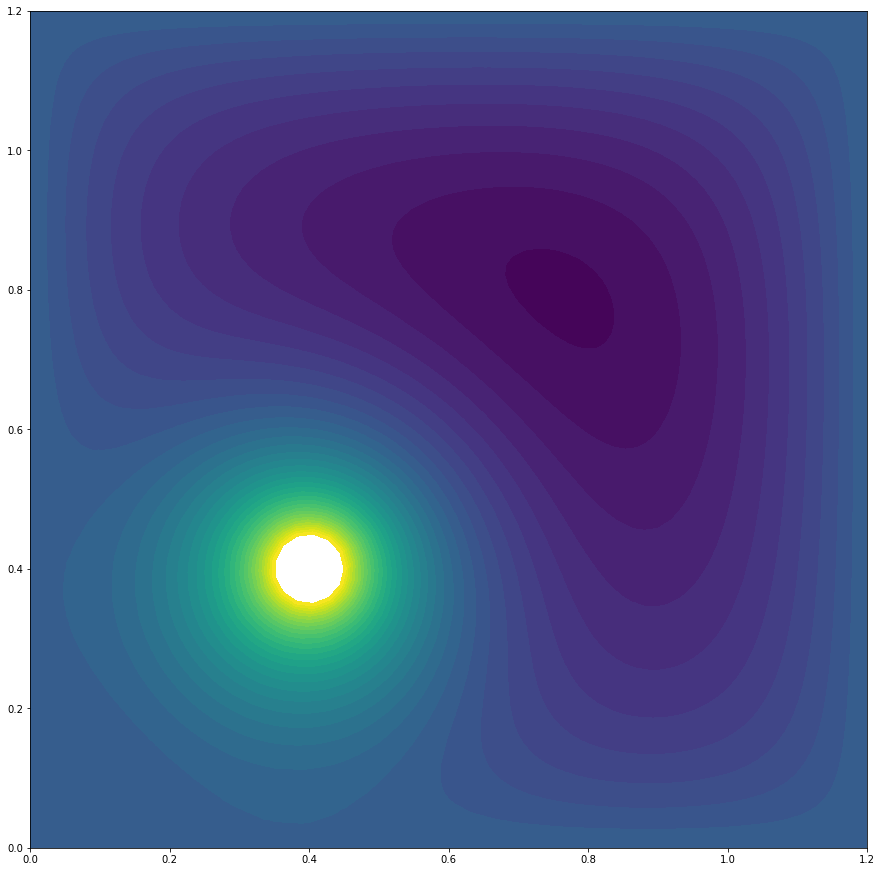

In [59]:
# Time-stepping
u = Function(V, name = 'temperature')
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_B.t = t
    f.t = t

    # Compute solution
    solve(a == L, u, bcs)

    # Plot solution
    #plot(u)
    vtkfile_u << u
    # Compute error at vertices
    #u_e = interpolate(u_D, V)
    # Compute maximum error at vertices
    vertex_values_u_D_1 = u_D_1.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D_1 - vertex_values_u))

#    error = np.abs(u_e.vector().array() - u.vector().array()).max()
    print('step = %d, t = %.2f, error = %.3g' % (n, t, error_max))

    # Update previous solution
    u_n.assign(u)

# Hold plot
#interactive()
mpl.figure(figsize=(15,20))
plot(u)

In [10]:
plot(u-u_D)

NameError: name 'u_D' is not defined